In [13]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np


mega_mendung_dir = 'trial/mega-mendung/'
kawung_dir = 'trial/batik-kawung'
parang_dir = 'trial/batik-parang'

mm_files = os.listdir(mega_mendung_dir)
kw_files = os.listdir(kawung_dir)
pr_files = os.listdir(parang_dir)

print(len(mm_files), len(kw_files), len(pr_files))

90 90 90


In [14]:
batik_motives = ['megamendung', 'kawung', 'parang']

if not os.path.exists('dataset'):
    for motive in batik_motives:
        os.makedirs(f'dataset/train/{motive}')
        os.makedirs(f'dataset/test/{motive}')
    print('Directories created!')
else:
    print('Directories already exist!')

train_size = 80

Directories created!


In [15]:
def prepare_dataset(im_files, source_dir, motive):
    for no, im in enumerate(im_files):
        if not im.startswith('.'):
            image = cv.imread(os.path.join(source_dir, im))
            image = cv.resize(image, (224, 224), interpolation = cv.INTER_AREA)

            if no < train_size:
                cv.imwrite(os.path.join(f'dataset/train/{motive}', f'{no}.jpg'), image)
            else:
                cv.imwrite(os.path.join(f'dataset/test/{motive}', f'{no}.jpg'), image)

In [16]:
prepare_dataset(mm_files, mega_mendung_dir, batik_motives[0])
prepare_dataset(kw_files, kawung_dir, batik_motives[1])
prepare_dataset(pr_files, parang_dir, batik_motives[2])

In [2]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, LeakyReLU, GlobalMaxPool2D, GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [3]:
train_path = './dataset/train'
test_path = './dataset/test'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2,
      rotation_range=360,
      fill_mode='nearest',
      zoom_range=0.2,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16,
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=6,
    color_mode='rgb'
)

Found 240 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [110]:
train_generator.class_indices

{'kawung': 0, 'megamendung': 1, 'parang': 2}

In [13]:
# clear_session()

# model = Sequential([
#     Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(200, 200, 3)),
#     MaxPool2D(2, 2),
#     # Conv2D(16, (3,3), padding='same', activation='relu'),
#     # MaxPool2D(2, 2),
#     Flatten(),
#     Dense(128, activation='relu', kernel_regularizer='l2'),
#     Dropout(0.2),
#     Dense(64, activation='relu', kernel_regularizer='l2'),
#     Dropout(0.2),
#     Dense(32, activation='relu', kernel_regularizer='l2'),
#     Dropout(0.2),
#     Dense(3, activation='softmax')
# ])

# model.compile(
#     optimizer=Adam(learning_rate=1e-2),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()

# history = model.fit(
#     train_generator,
#     validation_data=validation_generator,
#     shuffle=True,
#     epochs=20
# )

In [62]:
clear_session()

base_model = InceptionV3(input_shape=(200, 200, 3), include_top=False, weights='imagenet')

base_model.trainable = False

# base_model.summary()

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAvgPool2D())
add_model.add(Dense(512, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(3, activation='softmax'))

model = add_model

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

log_dir = "logs/" + 'inception Adam 512 0.2 GlobalAvgPool lr-3'
# datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=240/16,
    validation_steps=30/6,
    shuffle=True,
    epochs=100,
    callbacks=[tensorboard_callback]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 22,853,411
Trainable params: 1,050,627
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/100
15/15 [==============================] - 28s 1s/step - loss: 2.8510 - accuracy: 0.4013 - v

In [69]:
model.save('./models/inceptionv3_adam1e-3_512dense_d0.2.h5')

In [106]:
# MobileNet Model
clear_session()

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=0.75,
    pooling='avg'    
)

base_model.trainable = False

# add_model = Sequential()
# add_model.add(transfer_model)
# add_model.add(GlobalAvgPool2D())
# add_model.add(Dense(512, activation='relu'))
# add_model.add(Dropout(0.2))
# add_model.add(Dense(3, activation='softmax'))

# mobilenet_model = add_model

mobilenet_model = Sequential([
    base_model,
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(3, activation='softmax')
])

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

mobilenet_model.summary()

log_dir = "logs/" + 'mobilenet_0.75_256_0.25_adam1e-4'
# datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=240/16,
    validation_steps=30/6,
    shuffle=True,
    epochs=50,
    callbacks=[tensorboard_callback]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.75_224 (Functi (None, 1280)              1382064   
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 1,710,771
Trainable params: 328,707
Non-trainable params: 1,382,064
_________________________________________________________________
Epoch 1/50
15/15 [==============================] - 16s 945ms/step - loss: 1.4064 - accuracy: 0.3850 - val_loss: 0.6971 - val_accuracy: 0.7667
Epoch 2/50
15/15 [==============================] - 12s 772ms/step - loss: 0.8674 - accuracy: 0

In [107]:
mobilenet_model.save('./models/mobilenet_0.75_256_0.25_adam1e-4.h5')

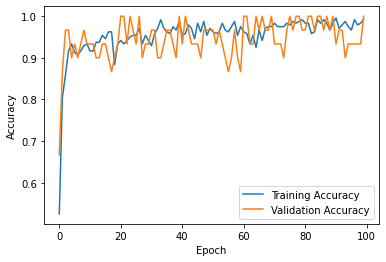

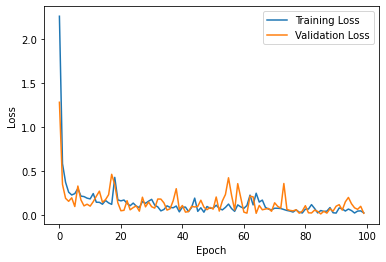

In [63]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [121]:
loaded_model = load_model('./models/inceptionv3_adam1e-3_512dense_d0.2.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 22,853,411
Trainable params: 1,050,627
Non-trainable params: 21,802,784
_________________________________________________________________


In [124]:
loaded_model = load_model('./models/mobilenet_0.75_256_0.25_adam1e-4.h5')
loaded_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.75_224 (Functi (None, 1280)              1382064   
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 1,710,771
Trainable params: 328,707
Non-trainable params: 1,382,064
_________________________________________________________________


117 ms ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


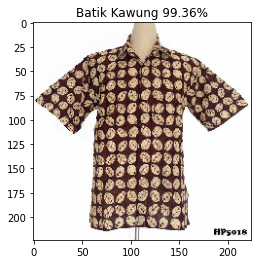

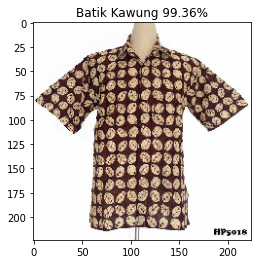

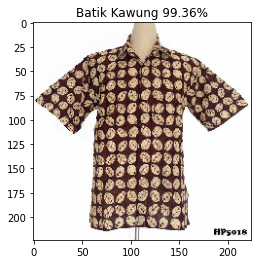

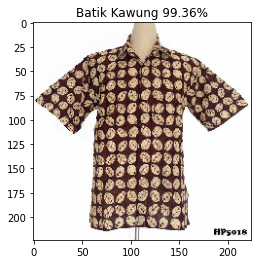

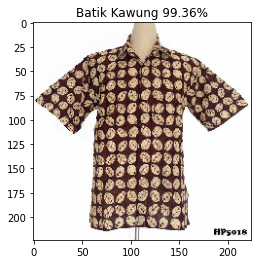

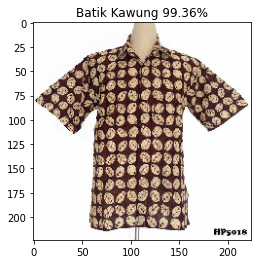

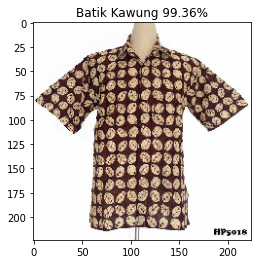

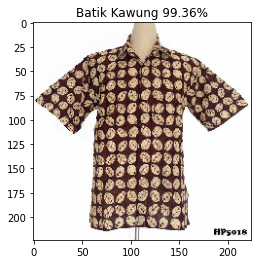

In [127]:
%%timeit
img_path = 'kawung1.jpeg'
img = load_img(img_path, target_size=(224, 224), grayscale=False)

img_array = img_to_array(img) / 255.0
img_array = tf.expand_dims(img_array, 0)

motives_list = ['Batik Kawung', 'Batik Megamendung', 'Batik Parang']

prediction = loaded_model(img_array)
pred_idx = np.argmax(prediction)
pred_motive = motives_list[pred_idx]
pred_confidence = prediction[0][pred_idx] * 100

plt.figure()
plt.title(f'{pred_motive} {pred_confidence:.2f}%')
plt.imshow(img)

In [128]:
!tflite_convert \
  --keras_model_file="models/mobilenet_0.75_256_0.25_adam1e-4.h5" \
  --output_file="models/mobilenet.tflite"

zsh:1: command not found: tflite_convert
